Set up environment and get dataset from Kaggle

In [45]:
import sys
import kagglehub
import os
import subprocess

# 1. Show the Python executable path
print("Python path:", sys.executable)

# 2. Show package versions using pip
def pkg_version(pkg_name):
    return subprocess.check_output(
        [sys.executable, "-m", "pip", "show", pkg_name],
        text=True
    ).split("Version: ")[1].splitlines()[0]

print("kaggle version:", pkg_version("kaggle"))
print("kagglehub version:", pkg_version("kagglehub"))

# 3. Download the AI-generated essays dataset
path = kagglehub.dataset_download("denvermagtibay/ai-generated-essays-dataset")
print("Dataset downloaded to:", path)

# 4. List the files in the dataset folder
print("Files in dataset folder:", os.listdir(path))


Python path: /Users/melody/projects/ai-essay-detection/.venv/bin/python
kaggle version: 1.7.4.5
kagglehub version: 0.3.12
Dataset downloaded to: /Users/melody/.cache/kagglehub/datasets/denvermagtibay/ai-generated-essays-dataset/versions/1
Files in dataset folder: ['AI Generated Essays Dataset.csv']


Preview first few rows of the csv

In [109]:
import pandas as pd
import os

# Re-set the dataset path (adjust to your actual downloaded path if needed)
dataset_path = kagglehub.dataset_download("denvermagtibay/ai-generated-essays-dataset")
files = os.listdir(dataset_path)

# Load the first CSV file from the dataset folder
csv_files = [f for f in files if f.lower().endswith(".csv")]
if csv_files:
    file_path = os.path.join(dataset_path, csv_files[0])
    print(f"Loading {csv_files[0]}...\n")
    df = pd.read_csv(file_path)
    print("Dataset preview:")
    display(df.head())

    # Save a copy into ./data folder
    save_path = os.path.join("data", csv_files[0])
    df.to_csv(save_path, index=False)
    print(f"\n✅ Saved a copy to {save_path}")
else:
    print("No CSV files found — check dataset folder contents.")


Loading AI Generated Essays Dataset.csv...

Dataset preview:


,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1



✅ Saved a copy to data/AI Generated Essays Dataset.csv


Extract features from string

In [47]:
import re, math, os
from collections import Counter
from itertools import islice

# --- minimal utilities ---
def sentences(text):
    # simple sentence splitter
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

def words(text):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+(?:\.\d+)?", text)

def ngrams(tokens, n=3):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

BASIC_STOPWORDS = {
    'the','a','an','and','or','but','if','then','so','because','as','of','in','on','for','to','with','by',
    'is','are','was','were','be','been','being','it','that','this','these','those','at','from','which',
    'we','you','they','he','she','i','me','my','our','your','their','its'
}

CONNECTIVES = [
    "however", "moreover", "furthermore", "additionally", "in conclusion",
    "in summary", "on the other hand", "in contrast", "nevertheless", "nonetheless",
    "therefore", "thus", "consequently", "overall", "first", "second", "third"
]
CONNECTIVE_RE = re.compile(r"\b(" + "|".join(map(re.escape, CONNECTIVES)) + r")\b", flags=re.I)

PASSIVE_RE = re.compile(r"\b(?:is|are|was|were|be|been|being)\s+\w+ed\b", flags=re.I)

def analyze_text(text):
    txt = (text or "").strip()
    toks = words(txt)
    sents = sentences(txt)
    if not toks or not sents:
        return {
            "word_count": 0, "sent_count": 0, "mean_sent_len": 0, "var_sent_len": 0,
            "ttr": 0, "stopword_ratio": 0, "trigram_repeat_ratio": 0,
            "connectives_per_100w": 0, "named_like_per_100w": 0,
            "digits_per_100w": 0, "passive_per_100w": 0, "punct_types": 0
        }

    # length & rhythm
    sent_lens = [len(words(s)) for s in sents]
    mean_len = sum(sent_lens)/len(sent_lens)
    var_len = sum((l-mean_len)**2 for l in sent_lens)/len(sent_lens)

    # lexical diversity
    wc = len(toks)
    unique = len(set(w.lower() for w in toks))
    ttr = unique / wc
    stop_ratio = sum(1 for w in toks if w.lower() in BASIC_STOPWORDS) / wc

    # repetition (trigram)
    tgs = ngrams([w.lower() for w in toks], 3)
    tg_counts = Counter(tgs)
    repeated = sum(c for tg, c in tg_counts.items() if c >= 2)
    trigram_repeat_ratio = (repeated / max(1, len(tgs)))

    # discourse/connectives
    conn = len(CONNECTIVE_RE.findall(txt))
    connectives_per_100w = 100 * conn / wc

    # specificity proxies (no spaCy): “named-like” = capitalized words not at sentence start
    named_like = re.findall(r"(?<![.!?]\s)(\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)", txt)
    named_like_per_100w = 100 * len(named_like) / wc
    digits_per_100w = 100 * len(re.findall(r"\b\d", txt)) / wc

    # passive voice proxy
    passive_per_100w = 100 * len(PASSIVE_RE.findall(txt)) / wc

    # punctuation variety
    puncts = set(re.findall(r"[;:—–\-(),\"'…!?]", txt))
    punct_types = len(puncts)

    return {
        "word_count": wc,
        "sent_count": len(sents),
        "mean_sent_len": mean_len,
        "var_sent_len": var_len,
        "ttr": ttr,
        "stopword_ratio": stop_ratio,
        "trigram_repeat_ratio": trigram_repeat_ratio,
        "connectives_per_100w": connectives_per_100w,
        "named_like_per_100w": named_like_per_100w,
        "digits_per_100w": digits_per_100w,
        "passive_per_100w": passive_per_100w,
        "punct_types": punct_types,
    }


Introduce scoring for AI-likeliness (V1)

In [48]:
import pandas as pd
import numpy as np

# 1) pick the text column (auto-guess, or set manually)
TEXT_COL = None
candidates = [c for c in df.columns if str(df[c].dtype) == 'object']
name_hints = ['text','essay','content','body','response','statement','article']
for c in df.columns:
    if any(h in c.lower() for h in name_hints):
        TEXT_COL = c
        break
if TEXT_COL is None and candidates:
    TEXT_COL = candidates[0]  # fallback
print("Using text column:", TEXT_COL)

# 2) compute features
feat_rows = []
for i, t in df[TEXT_COL].fillna("").items():
    feat_rows.append(analyze_text(str(t)))
feat_df = pd.DataFrame(feat_rows, index=df.index)

# 3) simple rule-based score (0–5). Tweak thresholds after you see distributions.
def score_row(r):
    s = 0
    # (a) unusually uniform sentences → lower variance is more AI-like
    if r["var_sent_len"] <= 12: s += 1
    # (b) high templatey connectives
    if r["connectives_per_100w"] >= 3: s += 1
    # (c) low specificity proxies
    if r["named_like_per_100w"] < 0.8 and r["digits_per_100w"] < 0.6: s += 1
    # (d) repetition of phrasing
    if r["trigram_repeat_ratio"] >= 0.02: s += 1
    # (e) mid-range lexical diversity (optional heuristic)
    if 0.35 <= r["ttr"] <= 0.55: s += 1
    return s

feat_df["ai_likelihood_score"] = feat_df.apply(score_row, axis=1)
feat_df["ai_flag_simple"] = feat_df["ai_likelihood_score"] >= 2  # threshold you can adjust

# 4) quick look
display(feat_df.describe().T[["mean","50%","min","max"]])
print("\nFlag rate (simple):", feat_df["ai_flag_simple"].mean().round(3))

# 5) join back for inspection
scored = pd.concat([df[[TEXT_COL]].copy(), feat_df], axis=1)
display(scored.head(10))


Using text column: text


,mean,50%,min,max
word_count,536.467123,516.000000,36.000000,1365.000000
sent_count,25.856164,25.000000,2.000000,82.000000
mean_sent_len,21.534163,20.590909,10.711538,95.285714
var_sent_len,129.488970,95.645663,0.250000,1206.330579
ttr,0.448054,0.439727,0.270362,0.842105
stopword_ratio,0.366105,0.368573,0.202435,0.456914
trigram_repeat_ratio,0.081789,0.068776,0.000000,0.323970
connectives_per_100w,0.296337,0.220507,0.000000,1.630435
named_like_per_100w,4.265712,4.068377,0.000000,15.000000
digits_per_100w,0.990040,0.781250,0.000000,5.947955



Flag rate (simple): 0.818


,text,word_count,sent_count,mean_sent_len,var_sent_len,ttr,stopword_ratio,trigram_repeat_ratio,connectives_per_100w,named_like_per_100w,digits_per_100w,passive_per_100w,punct_types,ai_likelihood_score,ai_flag_simple
0,"Machine learning, a subset of artificial intel...",96,4,24.000000,12.000000,0.739583,0.312500,0.000000,0.000000,1.041667,0.000000,0.000000,1,1,False
1,"A decision tree, a prominent machine learning ...",105,6,17.500000,19.583333,0.761905,0.238095,0.000000,0.952381,0.000000,0.000000,0.952381,2,1,False
2,"Education, a cornerstone of societal progress,...",95,5,19.000000,31.200000,0.800000,0.242105,0.000000,1.052632,1.052632,0.000000,0.000000,2,0,False
3,"Computers, the backbone of modern technology, ...",92,5,18.400000,24.640000,0.771739,0.271739,0.000000,0.000000,1.086957,0.000000,0.000000,1,0,False
4,"Chess, a timeless game of strategy and intelle...",112,6,18.666667,14.555556,0.732143,0.285714,0.000000,0.000000,0.892857,0.892857,0.000000,3,0,False
5,"Calculus, a cornerstone of mathematical explor...",129,6,21.500000,20.916667,0.674419,0.325581,0.015748,0.000000,2.325581,0.775194,0.000000,2,0,False
6,"Electronics, the backbone of modern technology...",122,6,20.333333,29.888889,0.688525,0.336066,0.000000,0.000000,4.918033,0.000000,0.000000,5,0,False
7,"Data Science, a multidisciplinary field at the...",129,6,21.500000,33.583333,0.744186,0.255814,0.000000,0.000000,0.775194,0.000000,0.000000,2,1,False
8,"Artificial Intelligence (AI), a branch of comp...",121,6,20.166667,10.138889,0.776860,0.256198,0.000000,0.000000,1.652893,0.000000,0.000000,4,1,False
9,"Laptops, compact and portable computing device...",123,6,20.500000,10.583333,0.747967,0.317073,0.000000,0.000000,0.813008,0.000000,0.000000,2,1,False


Compare with original generated field

In [49]:
# New cell — show text, simple flag, and original generated column
TEXT_COL_NAME = TEXT_COL  # from Cell 2
LABEL_COL_NAME = "generated"  # replace if your column has a different name

comparison_df = df[[TEXT_COL_NAME, LABEL_COL_NAME]].copy()
comparison_df["ai_flag_simple"] = feat_df["ai_flag_simple"]

display(comparison_df.head(10))


,text,generated,ai_flag_simple
0,"Machine learning, a subset of artificial intel...",1,False
1,"A decision tree, a prominent machine learning ...",1,False
2,"Education, a cornerstone of societal progress,...",1,False
3,"Computers, the backbone of modern technology, ...",1,False
4,"Chess, a timeless game of strategy and intelle...",1,False
5,"Calculus, a cornerstone of mathematical explor...",1,False
6,"Electronics, the backbone of modern technology...",1,False
7,"Data Science, a multidisciplinary field at the...",1,False
8,"Artificial Intelligence (AI), a branch of comp...",1,False
9,"Laptops, compact and portable computing device...",1,False


Accuracy of the current scoring analysis

In [50]:
import pandas as pd
import numpy as np

# Column names carried over from earlier cells:
TEXT_COL_NAME = TEXT_COL              # from Cell 2 auto-detect or manual set
LABEL_COL_NAME = "generated"          # <-- change if your CSV uses a different label name

# 1) Build comparison frame
comparison_df = pd.DataFrame({
    "text": df[TEXT_COL_NAME],
    "ai_flag_simple": feat_df["ai_flag_simple"]
})

# 2) Normalize original label to boolean (AI=True, Human=False) where possible
def normalize_label(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    true_vals = {"1","true","yes","ai","generated","ai_generated","is_ai","is_generated"}
    false_vals = {"0","false","no","human","not_generated","is_human"}
    if s in true_vals:
        return True
    if s in false_vals:
        return False
    # try numeric
    try:
        return bool(int(s))
    except:
        return np.nan

if LABEL_COL_NAME in df.columns:
    comparison_df["generated_label"] = df[LABEL_COL_NAME].apply(normalize_label)
else:
    raise ValueError(f"Label column '{LABEL_COL_NAME}' not found. Update LABEL_COL_NAME to match your CSV.")

# 3) Drop rows without a usable ground-truth label
eval_df = comparison_df.dropna(subset=["generated_label"]).copy()

# 4) Compute metrics
y_true = eval_df["generated_label"].astype(bool).values
y_pred = eval_df["ai_flag_simple"].astype(bool).values

tp = int(((y_pred == True)  & (y_true == True)).sum())
tn = int(((y_pred == False) & (y_true == False)).sum())
fp = int(((y_pred == True)  & (y_true == False)).sum())
fn = int(((y_pred == False) & (y_true == True)).sum())

def safe_div(a, b): 
    return (a / b) if b else 0.0

accuracy  = safe_div(tp + tn, tp + tn + fp + fn)
precision = safe_div(tp, tp + fp)   # P(pred=AI | AI)
recall    = safe_div(tp, tp + fn)   # P(pred=AI | true AI)
f1        = safe_div(2*precision*recall, precision + recall)

print(f"Evaluated on {len(eval_df)} rows (dropped {len(comparison_df)-len(eval_df)} unlabeled/unknown).")
print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame([[tn, fp],[fn, tp]], 
                   index=["Human", "AI"], 
                   columns=["Pred Human","Pred AI"]))

print("\nMetrics (AI = positive class):")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1       : {f1:.3f}")

# 5) Peek at a few examples that disagree (useful for threshold tuning)
disagreements = eval_df[eval_df["ai_flag_simple"] != eval_df["generated_label"]].head(5)
print("\nSample disagreements (showing first 5):")
display(disagreements[["text","generated_label","ai_flag_simple"]])


Evaluated on 1460 rows (dropped 0 unlabeled/unknown).

Confusion matrix (rows=true, cols=pred):
       Pred Human  Pred AI
Human         196     1179
AI             70       15

Metrics (AI = positive class):
Accuracy : 0.145
Precision: 0.013
Recall   : 0.176
F1       : 0.023

Sample disagreements (showing first 5):


,text,generated_label,ai_flag_simple
0,"Machine learning, a subset of artificial intel...",True,False
1,"A decision tree, a prominent machine learning ...",True,False
2,"Education, a cornerstone of societal progress,...",True,False
3,"Computers, the backbone of modern technology, ...",True,False
4,"Chess, a timeless game of strategy and intelle...",True,False


Fixing scoring analysis for better accuracy (V2)

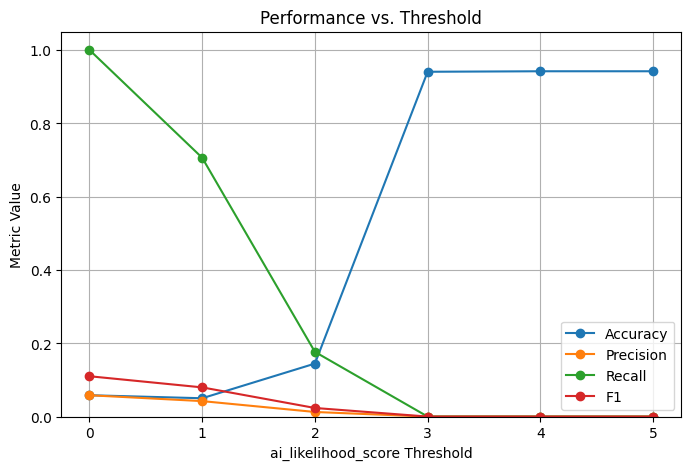

,threshold,accuracy,precision,recall,f1
0,0,0.058219,0.058219,1.000000,0.110032
1,1,0.050000,0.042194,0.705882,0.079628
2,2,0.144521,0.012563,0.176471,0.023456
3,3,0.940411,0.000000,0.000000,0.000000
4,4,0.941781,0.000000,0.000000,0.000000
5,5,0.941781,0.000000,0.000000,0.000000


,threshold,accuracy,precision,recall,f1
0,0,0.058219,0.058219,1.000000,0.110032
1,1,0.050000,0.042194,0.705882,0.079628
2,2,0.144521,0.012563,0.176471,0.023456
3,3,0.940411,0.000000,0.000000,0.000000
4,4,0.941781,0.000000,0.000000,0.000000
5,5,0.941781,0.000000,0.000000,0.000000


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make sure we still have the normalized label
if "generated_label" not in comparison_df.columns:
    comparison_df["generated_label"] = df[LABEL_COL_NAME].apply(normalize_label)

# Only evaluate rows with a known label
eval_df = pd.concat([feat_df["ai_likelihood_score"], comparison_df["generated_label"], df[TEXT_COL_NAME]], axis=1).dropna(subset=["generated_label"])
y_true = eval_df["generated_label"].astype(bool).values

thresholds = range(0, 6)  # score cutoffs from 0 to 5
results = []

for t in thresholds:
    y_pred = (eval_df["ai_likelihood_score"] >= t).values
    
    tp = int(((y_pred == True)  & (y_true == True)).sum())
    tn = int(((y_pred == False) & (y_true == False)).sum())
    fp = int(((y_pred == True)  & (y_true == False)).sum())
    fn = int(((y_pred == False) & (y_true == True)).sum())
    
    def safe_div(a, b): return (a / b) if b else 0.0
    
    accuracy  = safe_div(tp + tn, tp + tn + fp + fn)
    precision = safe_div(tp, tp + fp)
    recall    = safe_div(tp, tp + fn)
    f1        = safe_div(2*precision*recall, precision + recall)
    
    results.append({
        "threshold": t,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

# Create DataFrame
res_df = pd.DataFrame(results)

# Plot metrics vs threshold
plt.figure(figsize=(8,5))
plt.plot(res_df["threshold"], res_df["accuracy"], marker="o", label="Accuracy")
plt.plot(res_df["threshold"], res_df["precision"], marker="o", label="Precision")
plt.plot(res_df["threshold"], res_df["recall"], marker="o", label="Recall")
plt.plot(res_df["threshold"], res_df["f1"], marker="o", label="F1")
plt.xlabel("ai_likelihood_score Threshold")
plt.ylabel("Metric Value")
plt.ylim(0, 1.05)
plt.xticks(thresholds)
plt.title("Performance vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Show table of results
display(res_df)

res_df.sort_values("recall", ascending=False)



Build a feature matrix

In [52]:
# X = features, y = ground truth
X = feat_df[[
    "var_sent_len","connectives_per_100w","named_like_per_100w","digits_per_100w",
    "trigram_repeat_ratio","ttr","word_count","punct_types","passive_per_100w","mean_sent_len","sent_count"
]].fillna(0)

y = comparison_df["generated_label"].astype(bool)


Train lightweight model: logistic regression with scaling (V3)

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_recall_curve

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")),
])

# Probability calibration improves threshold tuning
cal_clf = CalibratedClassifierCV(pipe, method="isotonic", cv=3)
cal_clf.fit(Xtr, ytr)

probs = cal_clf.predict_proba(Xte)[:,1]


Compute with rule-based accuracy

Rule-based baseline accuracy (test split): 0.134

Best threshold meeting accuracy>=baseline:
{'thr': 0.195, 'f1': 1.0, 'prec': 1.0, 'rec': 1.0, 'acc': 1.0}


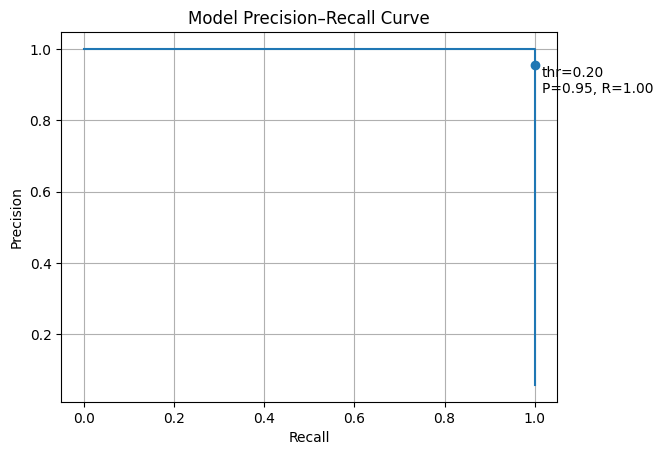

,threshold,precision,recall,f1,accuracy
0,0.000,0.057534,1.0,0.108808,0.057534
1,0.005,0.875000,1.0,0.933333,0.991781
2,0.010,0.875000,1.0,0.933333,0.991781
3,0.015,0.875000,1.0,0.933333,0.991781
4,0.020,0.875000,1.0,0.933333,0.991781


,threshold,precision,recall,f1,accuracy
59,0.295,1.0,1.0,1.0,1.0
74,0.370,1.0,1.0,1.0,1.0
54,0.270,1.0,1.0,1.0,1.0
53,0.265,1.0,1.0,1.0,1.0
52,0.260,1.0,1.0,1.0,1.0
51,0.255,1.0,1.0,1.0,1.0
50,0.250,1.0,1.0,1.0,1.0
49,0.245,1.0,1.0,1.0,1.0
48,0.240,1.0,1.0,1.0,1.0
47,0.235,1.0,1.0,1.0,1.0


In [54]:
# Continue from your code where `probs`, Xte, yte exist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_recall_curve

# --- 1) Baseline from your earlier rule-based flags on the same test split ---
# Requires feat_df["ai_flag_simple"] from the earlier rule-based step, aligned by index to X.
try:
    y_baseline_pred = feat_df.loc[Xte.index, "ai_flag_simple"].astype(bool).values
    baseline_acc = accuracy_score(yte, y_baseline_pred)
    print(f"Rule-based baseline accuracy (test split): {baseline_acc:.3f}")
except Exception as e:
    baseline_acc = 0.0
    print("Couldn't compute rule-based baseline (fallback to 0.0). Error:", e)

# --- 2) Threshold sweep under an accuracy constraint ---
thresholds = np.linspace(0, 1, 201)
best = {"thr": 0.5, "f1": -1, "prec": 0, "rec": 0, "acc": 0}

for t in thresholds:
    yhat = (probs >= t)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, yhat, average="binary", zero_division=0)
    acc = accuracy_score(yte, yhat)
    if acc >= baseline_acc and f1 > best["f1"]:
        best = {"thr": float(t), "f1": float(f1), "prec": float(prec), "rec": float(rec), "acc": float(acc)}

print("\nBest threshold meeting accuracy>=baseline:")
print(best)

# Full table if you want to inspect all thresholds:
rows = []
for t in thresholds:
    yhat = (probs >= t)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, yhat, average="binary", zero_division=0)
    acc = accuracy_score(yte, yhat)
    rows.append({"threshold": t, "precision": prec, "recall": rec, "f1": f1, "accuracy": acc})
res_df_model = pd.DataFrame(rows)

# --- 3) Precision–Recall curve for the model probabilities ---
precisions, recalls, pr_thresholds = precision_recall_curve(yte, probs)

plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Model Precision–Recall Curve")
plt.grid(True)

# mark the chosen threshold on the PR curve (nearest point)
if len(pr_thresholds):
    # find nearest PR point to best['thr']
    idx = np.argmin(np.abs(pr_thresholds - best["thr"]))
    plt.scatter(recalls[idx], precisions[idx])
    plt.annotate(f"thr={best['thr']:.2f}\nP={precisions[idx]:.2f}, R={recalls[idx]:.2f}",
                 (recalls[idx], precisions[idx]), xytext=(5, -20), textcoords="offset points")

plt.show()

# Also show metrics vs threshold for reference
display(res_df_model.head())
display(res_df_model.sort_values("f1", ascending=False).head(10))


Count of accurate detection of AI generation

In [55]:
import numpy as np
import pandas as pd

# Use the chosen threshold
chosen_threshold = 0.20  # from your PR curve

# Predictions from model
y_pred = (probs >= chosen_threshold)

# Confusion matrix counts
tp = int(((y_pred == True)  & (yte == True)).sum())   # AI essays correctly flagged as AI
tn = int(((y_pred == False) & (yte == False)).sum())  # Human essays correctly left unflagged
fp = int(((y_pred == True)  & (yte == False)).sum())  # Human essays incorrectly flagged as AI
fn = int(((y_pred == False) & (yte == True)).sum())   # AI essays missed (predicted human)

print(f"Correct AI detections (True Positives): {tp}")
print(f"Correct Human detections (True Negatives): {tn}")
print(f"Incorrectly flagged Humans (False Positives): {fp}")
print(f"Missed AI essays (False Negatives): {fn}")
print(f"\nTotal in test set: {len(yte)}")


Correct AI detections (True Positives): 21
Correct Human detections (True Negatives): 344
Incorrectly flagged Humans (False Positives): 0
Missed AI essays (False Negatives): 0

Total in test set: 365


Run stratified K fold for cross-validation (V4)

In [56]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

# Use the same features and labels from before
X_cv = X  # from earlier: feat_df[feature_columns]
y_cv = y  # from earlier: comparison_df["generated_label"]

# Define Stratified K-fold (e.g., 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model pipeline (same as before, without explicit calibration for simplicity)
pipe_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")),
])

# Evaluate precision, recall, accuracy, f1 across folds
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = cross_validate(pipe_cv, X_cv, y_cv, cv=kf, scoring=scoring, return_train_score=False)

# Print mean and std for each metric
for metric in scoring:
    mean_score = np.mean(cv_results[f"test_{metric}"])
    std_score = np.std(cv_results[f"test_{metric}"])
    print(f"{metric.capitalize():<10} : {mean_score:.3f} ± {std_score:.3f}")


Accuracy   : 0.984 ± 0.004
Precision  : 0.789 ± 0.044
Recall     : 1.000 ± 0.000
F1         : 0.882 ± 0.027


Find the better trade-off point for higher accuracy and precision (V5)

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# --- Inputs ---
# probs: model scores on test set (from your calibrated logistic)
# yte:   true labels (boolean array/Series: True=AI, False=Human)

RECALL_FLOOR = 0.98   # keep recall high (catch ≥98% of AI)
ACC_FLOOR    = None   # optionally set e.g., 0.98 to enforce accuracy; or leave None

thresholds = np.linspace(0, 1, 201)

rows = []
for t in thresholds:
    y_pred = (probs >= t)
    tp = int(((y_pred == True)  & (yte == True)).sum())
    tn = int(((y_pred == False) & (yte == False)).sum())
    fp = int(((y_pred == True)  & (yte == False)).sum())
    fn = int(((y_pred == False) & (yte == True)).sum())

    prec = precision_score(yte, y_pred, zero_division=0)
    rec  = recall_score(yte, y_pred, zero_division=0)
    acc  = accuracy_score(yte, y_pred)
    f1   = f1_score(yte, y_pred, zero_division=0)

    rows.append({
        "threshold": t, "precision": prec, "recall": rec, "accuracy": acc, "f1": f1,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    })

res = pd.DataFrame(rows)

# Filter by constraints: keep recall high (and accuracy if you set ACC_FLOOR)
mask = res["recall"] >= RECALL_FLOOR
if ACC_FLOOR is not None:
    mask &= res["accuracy"] >= ACC_FLOOR

candidates = res[mask].copy()

print(f"Threshold candidates meeting recall ≥ {RECALL_FLOOR}"
      + (f" and accuracy ≥ {ACC_FLOOR}" if ACC_FLOOR is not None else "")
      + f": {len(candidates)}")

# (A) Best precision among candidates (fewest false positives)
best_by_precision = candidates.sort_values(["precision","threshold"], ascending=[False, True]).head(1)
print("\nBest (maximize precision under constraints):")
display(best_by_precision[["threshold","precision","recall","accuracy","f1","TP","FP","FN","TN"]])

# (B) Alternatively, explicitly minimize FP (ties broken by higher recall, then precision)
best_by_fp = candidates.sort_values(["FP","recall","precision","threshold"],
                                    ascending=[True, False, False, True]).head(1)
print("\nBest (minimize FP under constraints):")
display(best_by_fp[["threshold","precision","recall","accuracy","f1","TP","FP","FN","TN"]])

# Show the top few candidates so you can compare
print("\nTop candidates (sorted by precision desc):")
display(candidates.sort_values(["precision","threshold"], ascending=[False, True]).head(10))

print("\nTop candidates (sorted by FP asc):")
display(candidates.sort_values(["FP","recall","precision","threshold"],
                               ascending=[True, False, False, True]).head(10))


Threshold candidates meeting recall ≥ 0.98: 89

Best (maximize precision under constraints):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344



Best (minimize FP under constraints):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344



Top candidates (sorted by precision desc):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344
40,0.200,1.0,1.0,1.0,1.0,21,0,0,344
41,0.205,1.0,1.0,1.0,1.0,21,0,0,344
42,0.210,1.0,1.0,1.0,1.0,21,0,0,344
43,0.215,1.0,1.0,1.0,1.0,21,0,0,344
44,0.220,1.0,1.0,1.0,1.0,21,0,0,344
45,0.225,1.0,1.0,1.0,1.0,21,0,0,344
46,0.230,1.0,1.0,1.0,1.0,21,0,0,344
47,0.235,1.0,1.0,1.0,1.0,21,0,0,344
48,0.240,1.0,1.0,1.0,1.0,21,0,0,344



Top candidates (sorted by FP asc):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344
40,0.200,1.0,1.0,1.0,1.0,21,0,0,344
41,0.205,1.0,1.0,1.0,1.0,21,0,0,344
42,0.210,1.0,1.0,1.0,1.0,21,0,0,344
43,0.215,1.0,1.0,1.0,1.0,21,0,0,344
44,0.220,1.0,1.0,1.0,1.0,21,0,0,344
45,0.225,1.0,1.0,1.0,1.0,21,0,0,344
46,0.230,1.0,1.0,1.0,1.0,21,0,0,344
47,0.235,1.0,1.0,1.0,1.0,21,0,0,344
48,0.240,1.0,1.0,1.0,1.0,21,0,0,344


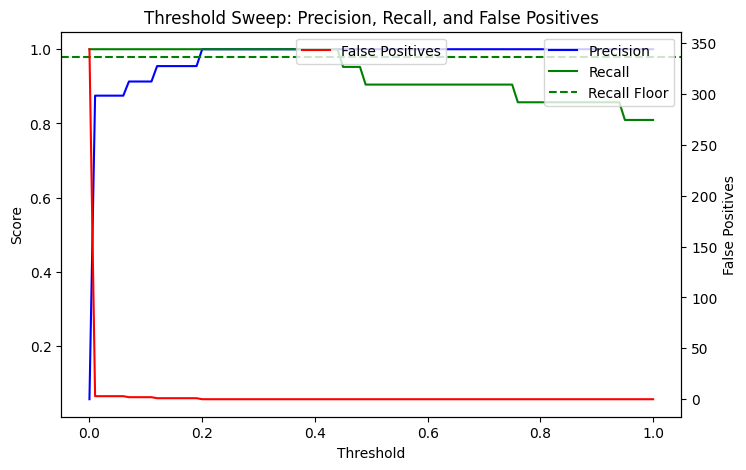

Best Threshold: 0.20
Precision at Best Threshold: 1.000
Recall at Best Threshold: 1.000
False Positives at Best Threshold: 0


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# We'll test thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
false_positives = []

RECALL_FLOOR = 0.98  # we don't want recall to drop below this

for t in thresholds:
    preds = (probs >= t).astype(int)
    
    precisions.append(precision_score(yte, preds))
    recalls.append(recall_score(yte, preds))
    false_positives.append(np.sum((preds == 1) & (yte == 0)))

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Precision & Recall
ax1.plot(thresholds, precisions, label="Precision", color="blue")
ax1.plot(thresholds, recalls, label="Recall", color="green")
ax1.axhline(RECALL_FLOOR, color="green", linestyle="--", label="Recall Floor")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.legend(loc="upper right")

# False positives on second axis
ax2 = ax1.twinx()
ax2.plot(thresholds, false_positives, label="False Positives", color="red")
ax2.set_ylabel("False Positives")
ax2.legend(loc="upper center")

plt.title("Threshold Sweep: Precision, Recall, and False Positives")
plt.show()

# Find best threshold where recall >= floor and precision is max
best_idx = max(
    ((i, p) for i, (p, r) in enumerate(zip(precisions, recalls)) if r >= RECALL_FLOOR),
    key=lambda x: x[1]
)[0]

print(f"Best Threshold: {thresholds[best_idx]:.2f}")
print(f"Precision at Best Threshold: {precisions[best_idx]:.3f}")
print(f"Recall at Best Threshold: {recalls[best_idx]:.3f}")
print(f"False Positives at Best Threshold: {false_positives[best_idx]}")


Confusion Matrix

In [59]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

RECALL_FLOOR = 0.98

# Find best threshold based on precision while keeping recall >= RECALL_FLOOR
for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(yte, preds))
    recalls.append(recall_score(yte, preds))

best_idx = max(
    ((i, p) for i, (p, r) in enumerate(zip(precisions, recalls)) if r >= RECALL_FLOOR),
    key=lambda x: x[1]
)[0]

best_threshold = thresholds[best_idx]
best_preds = (probs >= best_threshold).astype(int)
cm = confusion_matrix(yte, best_preds)

print("\nConfusion Matrix (rows: true, cols: predicted)")
print(cm)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")



Confusion Matrix (rows: true, cols: predicted)
[[344   0]
 [  0  21]]
TN: 344, FP: 0, FN: 0, TP: 21


Feature Representation Bias

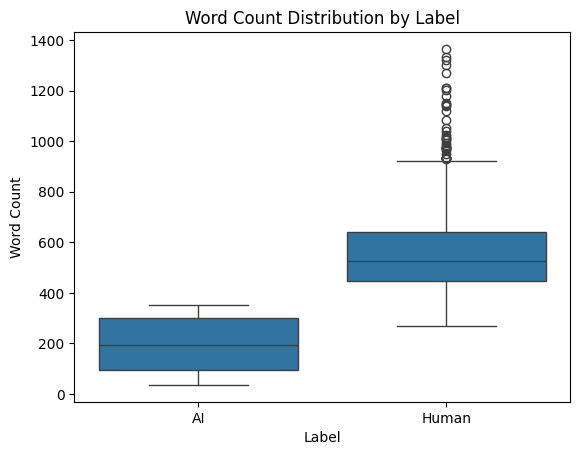

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Merge label onto your features
feat_with_label = feat_df.join(comparison_df["generated_label"])

# Optional: make the x-axis nicer to read
feat_with_label["label_str"] = feat_with_label["generated_label"].map({True: "AI", False: "Human"})

# Boxplot of word count by label
sns.boxplot(x="label_str", y="word_count", data=feat_with_label)
plt.title("Word Count Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()


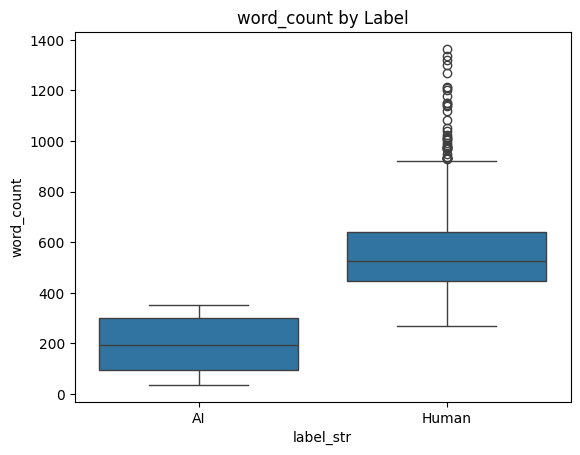

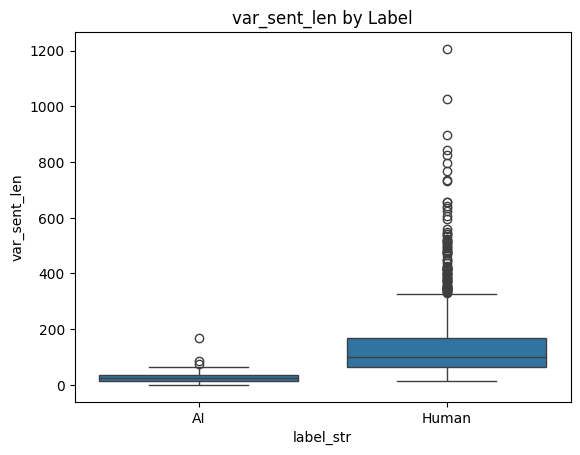

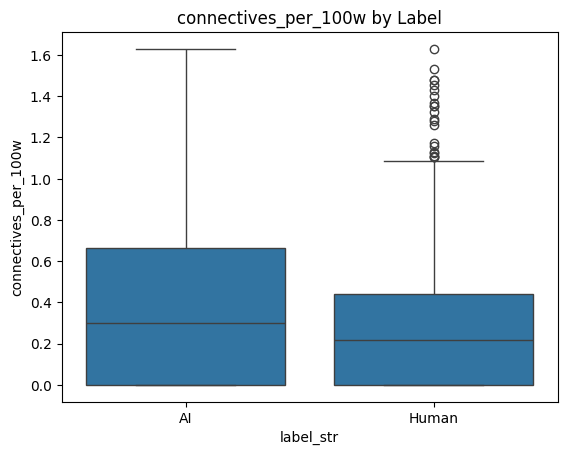

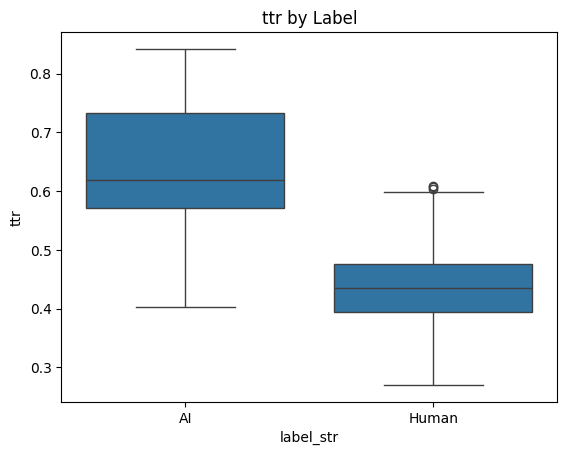

In [61]:
for col in ["word_count", "var_sent_len", "connectives_per_100w", "ttr"]:
    sns.boxplot(x="label_str", y=col, data=feat_with_label)
    plt.title(f"{col} by Label")
    plt.show()


Summary of the score range across all four groups: Accuracy, Precision, Recall and F1.

In [68]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

# Use the same features and labels from before
X_cv = X  # from earlier: feat_df[feature_columns]
y_cv = y  # from earlier: comparison_df["generated_label"]

# Define Stratified K-fold (e.g., 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model pipeline (same as before, without explicit calibration for simplicity)
pipe_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")),
])

# Evaluate precision, recall, accuracy, f1 across folds
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = cross_validate(pipe_cv, X_cv, y_cv, cv=kf, scoring=scoring, return_train_score=False)

# Print mean and std for each metric
for metric in scoring:
    mean_score = np.mean(cv_results[f"test_{metric}"])
    std_score = np.std(cv_results[f"test_{metric}"])
    print(f"{metric.capitalize():<10} : {mean_score:.3f} ± {std_score:.3f}")


Accuracy   : 0.984 ± 0.004
Precision  : 0.789 ± 0.044
Recall     : 1.000 ± 0.000
F1         : 0.882 ± 0.027


Define possible group for bias:
Essay length (Short vs. long essays)
Writing style features (High vs. low lexical diversity, punctuation usage)
Topic/domain (e.g., literature vs. science essays)
Readability levels (Easy vs. complex)

Test bias for the following group (V1):
Word count -> Essay Length
Lexical diversity -> Writing style, vocab diversity
Punctuation frequency -> Writing style

In [62]:
#count punctuation per entry

import re
import pandas as pd

# 1) Decide which text column to use
#    Prefer TEXT_COL_NAME (from earlier), else TEXT_COL, else try to auto-pick a likely text column.
if "TEXT_COL_NAME" in globals() and TEXT_COL_NAME in df.columns:
    TEXT_COL_USED = TEXT_COL_NAME
elif "TEXT_COL" in globals() and TEXT_COL in df.columns:
    TEXT_COL_USED = TEXT_COL
else:
    candidates = [c for c in df.columns if df[c].dtype == "object"]
    name_hints = ["text","essay","content","body","response","statement","article"]
    TEXT_COL_USED = next((c for c in candidates if any(h in c.lower() for h in name_hints)), candidates[0])

print("Using text column:", TEXT_COL_USED)

# 2) Define simple token/word and punctuation counters
WORD_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+(?:\.\d+)?")
# Include common punctuation marks (add/remove as you wish)
PUNCT_RE = re.compile(r"[.,;:!?\"'()\-–—…]")

def punct_per_100_words(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return 0.0
    wc = len(WORD_RE.findall(text))
    if wc == 0:
        return 0.0
    punct_count = len(PUNCT_RE.findall(text))
    return 100.0 * punct_count / wc

# 3) Compute the column in the same index space as your existing feature frame
#    If you already have feat_with_label (features joined with labels), use its index to align.
target_index = feat_with_label.index if 'feat_with_label' in globals() else df.index
punct_series = df.loc[target_index, TEXT_COL_USED].fillna("").apply(punct_per_100_words)

# 4) Attach to feat_with_label (create it if needed)
if 'feat_with_label' not in globals():
    # If you don't already have it, start with feat_df and join your label column
    label_col = "generated_label" if "generated_label" in comparison_df.columns else "generated"
    tmp = comparison_df[label_col] if label_col in comparison_df.columns else df[label_col]
    feat_with_label = feat_df.join(tmp.rename("generated_label"))

feat_with_label["punct_per_100w"] = punct_series

# 5) Create punctuation groups by median split
median_punc = feat_with_label["punct_per_100w"].median()
feat_with_label["punc_group"] = feat_with_label["punct_per_100w"].apply(
    lambda x: "Low Punctuation" if x <= median_punc else "High Punctuation"
)

print("Created columns: 'punct_per_100w' and 'punc_group'.")
print("Median punct/100w:", round(median_punc, 3))
feat_with_label[["punct_per_100w","punc_group"]].head()


Using text column: text
Created columns: 'punct_per_100w' and 'punc_group'.
Median punct/100w: 12.234


,punct_per_100w,punc_group
0,16.666667,High Punctuation
1,18.095238,High Punctuation
2,24.210526,High Punctuation
3,21.739130,High Punctuation
4,20.535714,High Punctuation


In [63]:
# Word count groups
median_wc = feat_with_label["word_count"].median()
feat_with_label["length_group"] = feat_with_label["word_count"].apply(
    lambda x: "Short" if x <= median_wc else "Long"
)

# Lexical diversity groups
median_ttr = feat_with_label["ttr"].median()
feat_with_label["ttr_group"] = feat_with_label["ttr"].apply(
    lambda x: "Low Diversity" if x <= median_ttr else "High Diversity"
)

# Punctuation frequency groups
median_punc = feat_with_label["punct_per_100w"].median()
feat_with_label["punc_group"] = feat_with_label["punct_per_100w"].apply(
    lambda x: "Low Punctuation" if x <= median_punc else "High Punctuation"
)


Reformat the dataset for easier processing of ML

In [64]:
import pandas as pd

# Make sure Xte, yte, y_pred exist from your train/test split
pred_series = pd.Series(y_pred.astype(int), index=Xte.index, name="y_pred")
true_series = pd.Series(yte.astype(int), index=Xte.index, name="generated_label")

# Restrict to test rows and bring in labels/preds
eval_df = feat_with_label.loc[Xte.index].copy()

# Ensure true label present
if "generated_label" not in eval_df.columns:
    eval_df = eval_df.join(true_series, how="left")

# Add predictions
eval_df = eval_df.join(pred_series, how="left")

# Quick sanity checks
print("Rows in eval_df:", len(eval_df))
print("Any missing preds?", eval_df["y_pred"].isna().sum())
print("Any missing labels?", eval_df["generated_label"].isna().sum())


Rows in eval_df: 365
Any missing preds? 0
Any missing labels? 0


In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def evaluate_groups_with_stats_df(df, group_col, true_col="generated_label", pred_col="y_pred"):
    results = []
    for grp, sub in df.groupby(group_col):
        y_true = sub[true_col].astype(int)
        y_pred_ = sub[pred_col].astype(int)
        results.append({
            group_col: grp,
            "Count": len(sub),
            "Accuracy": accuracy_score(y_true, y_pred_),
            "Precision": precision_score(y_true, y_pred_, zero_division=0),
            "Recall": recall_score(y_true, y_pred_, zero_division=0),
            "F1-score": f1_score(y_true, y_pred_, zero_division=0),
        })
    return pd.DataFrame(results)


Define bias function for each group
Add chi-square test to look at statistical significance for performance gap between the groups

In [66]:
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
import numpy as np

def evaluate_groups_with_stats(df, group_col, y_true_col, y_pred):
    print(f"\n=== Bias Check by {group_col} ===")
    
    # Store confusion matrices for all groups
    contingency = []

    for group in df[group_col].unique():
        idx = df[group_col] == group
        y_true_group = df.loc[idx, y_true_col]
        y_pred_group = y_pred[idx]

        acc = accuracy_score(y_true_group, y_pred_group)
        prec = precision_score(y_true_group, y_pred_group)
        rec = recall_score(y_true_group, y_pred_group)

        print(f"\nGroup: {group}")
        print(f"  Accuracy : {acc:.3f}")
        print(f"  Precision: {prec:.3f}")
        print(f"  Recall   : {rec:.3f}")

        # Confusion matrix: [[TN, FP], [FN, TP]]
        cm = confusion_matrix(y_true_group, y_pred_group)
        contingency.append(cm.flatten())  # Flatten into [TN, FP, FN, TP]

    # Convert to array for chi-square
    contingency_array = np.array(contingency)

    # Chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency_array)
    print("\nChi-square test results:")
    print(f"  Chi2 statistic: {chi2:.3f}")
    print(f"  p-value       : {p_value:.4f}")

    if p_value < 0.05:
        print("⚠️ Performance difference is statistically significant (possible bias).")
    else:
        print("✅ No statistically significant bias detected between groups.")


In [67]:
print("📏 Length Group Bias Check")
display(evaluate_groups_with_stats_df(eval_df, "length_group"))

print("🔠 Lexical Diversity Group Bias Check")
display(evaluate_groups_with_stats_df(eval_df, "ttr_group"))

print("✏️ Punctuation Group Bias Check")
display(evaluate_groups_with_stats_df(eval_df, "punc_group"))


📏 Length Group Bias Check


,length_group,Count,Accuracy,Precision,Recall,F1-score
0,Long,184,1.000000,0.0,0.000000,0.000000
1,Short,181,0.977901,1.0,0.809524,0.894737


🔠 Lexical Diversity Group Bias Check


,ttr_group,Count,Accuracy,Precision,Recall,F1-score
0,High Diversity,172,0.982558,1.0,0.85,0.918919
1,Low Diversity,193,0.994819,0.0,0.00,0.000000


✏️ Punctuation Group Bias Check


,punc_group,Count,Accuracy,Precision,Recall,F1-score
0,High Punctuation,183,0.989071,1.0,0.888889,0.941176
1,Low Punctuation,182,0.989011,1.0,0.333333,0.500000


Further see the bias for each group

In [71]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import numpy as np

def per_group_metrics(df, group_col, y_true="generated_label", y_pred="y_pred"):
    rows = []
    for g, sub in df.groupby(group_col):
        yT = sub[y_true].astype(int).values
        yP = sub[y_pred].astype(int).values
        tn, fp, fn, tp = confusion_matrix(yT, yP).ravel()
        acc = accuracy_score(yT, yP)
        prec = precision_score(yT, yP, zero_division=0)
        rec = recall_score(yT, yP, zero_division=0)
        f1 = f1_score(yT, yP, zero_division=0)
        rows.append({
            "group": g, "count": len(sub),
            "TP": tp, "FP": fp, "FN": fn, "TN": tn,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
            "FNR": (fn / (tp+fn)) if (tp+fn) else 0.0,                 # False Negative Rate
            "FPR": (fp / (fp+tn)) if (fp+tn) else 0.0,                 # False Positive Rate
            "selection_rate": (yP.mean())                              # share predicted AI
        })
    out = pd.DataFrame(rows).sort_values("group").reset_index(drop=True)
    # Disparities vs best group
    for metric in ["recall","precision","accuracy","FNR","FPR","selection_rate","f1"]:
        out[f"{metric}_gap_vs_best"] = out[metric].max() - out[metric]
    return out


In [74]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import numpy as np
import pandas as pd

def per_group_metrics(df, group_col, y_true="generated_label", y_pred="y_pred"):
    rows = []
    for g, sub in df.groupby(group_col):
        yT = sub[y_true].astype(int).values
        yP = sub[y_pred].astype(int).values

        # Force a 2x2 confusion matrix even if a class is missing in this subgroup
        cm = confusion_matrix(yT, yP, labels=[0, 1])
        # cm = [[TN, FP],
        #       [FN, TP]]
        tn, fp, fn, tp = cm.ravel()

        # Metrics (safe when a class is missing)
        acc = accuracy_score(yT, yP)
        prec = precision_score(yT, yP, zero_division=0)
        rec  = recall_score(yT, yP, zero_division=0)
        f1   = f1_score(yT, yP, zero_division=0)

        # Rates (guard against division by zero)
        fnr = (fn / (tp + fn)) if (tp + fn) else 0.0
        fpr = (fp / (fp + tn)) if (fp + tn) else 0.0
        sel = yP.mean()  # selection rate = share predicted AI

        rows.append({
            "group": g, "count": len(sub),
            "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
            "FNR": fnr, "FPR": fpr, "selection_rate": sel
        })

    out = pd.DataFrame(rows).sort_values("group").reset_index(drop=True)

    # Disparities vs best group (max value considered "best" except for error rates where lower is better)
    for metric in ["recall","precision","accuracy","f1","selection_rate"]:
        out[f"{metric}_gap_vs_best"] = out[metric].max() - out[metric]
    for metric in ["FNR","FPR"]:
        out[f"{metric}_gap_vs_best"] = out[metric] - out[metric].min()

    return out


In [77]:
len_report = per_group_metrics(eval_df, "length_group")
ttr_report = per_group_metrics(eval_df, "ttr_group")
punc_report = per_group_metrics(eval_df, "punc_group")

print("=== Length Group Bias Report ===")
display(len_report[["group","count","TP","FP","FN","TN","precision","recall","FNR","selection_rate",
                    "precision_gap_vs_best","recall_gap_vs_best","FNR_gap_vs_best"]])

print("=== Lexical Diversity Bias Report ===")
display(ttr_report[["group","count","TP","FP","FN","TN","precision","recall","FNR","selection_rate",
                    "precision_gap_vs_best","recall_gap_vs_best","FNR_gap_vs_best"]])

print("=== Punctuation Group Bias Report ===")
display(punc_report[[
    "group","count","TP","FP","FN","TN",
    "precision","recall","FNR","selection_rate",
    "precision_gap_vs_best","recall_gap_vs_best","FNR_gap_vs_best"
]])


=== Length Group Bias Report ===


,group,count,TP,FP,FN,TN,precision,recall,FNR,selection_rate,precision_gap_vs_best,recall_gap_vs_best,FNR_gap_vs_best
0,Long,184,0,0,0,184,0.0,0.000000,0.000000,0.000000,1.0,0.809524,0.000000
1,Short,181,17,0,4,160,1.0,0.809524,0.190476,0.093923,0.0,0.000000,0.190476


=== Lexical Diversity Bias Report ===


,group,count,TP,FP,FN,TN,precision,recall,FNR,selection_rate,precision_gap_vs_best,recall_gap_vs_best,FNR_gap_vs_best
0,High Diversity,172,17,0,3,152,1.0,0.85,0.15,0.098837,0.0,0.00,0.00
1,Low Diversity,193,0,0,1,192,0.0,0.00,1.00,0.000000,1.0,0.85,0.85


=== Punctuation Group Bias Report ===


,group,count,TP,FP,FN,TN,precision,recall,FNR,selection_rate,precision_gap_vs_best,recall_gap_vs_best,FNR_gap_vs_best
0,High Punctuation,183,16,0,2,165,1.0,0.888889,0.111111,0.087432,0.0,0.000000,0.000000
1,Low Punctuation,182,1,0,2,179,1.0,0.333333,0.666667,0.005495,0.0,0.555556,0.555556


Calculation method
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
FNR = FN / (TP + FN) = 1 - Recall
Selection Rate = (TP + FP) / Total Sample

From this result, we can see that long word length, short lexical density, and low punctuation count has near 0 TP (meaning that no AI generation data points in this dataset for these categories).

Such data bias of underrepresentation of AI sample is presented in the table below:

In [81]:
import pandas as pd

def bias_distribution(df, group_col, label_col="generated_label"):
    result = []
    for group, sub in df.groupby(group_col):
        total = len(sub)
        ai_count = (sub[label_col] == 1).sum()
        human_count = (sub[label_col] == 0).sum()
        ai_pct = (ai_count / total) * 100 if total > 0 else 0
        result.append({
            "Group": group,
            "Total Samples": total,
            "AI Samples": ai_count,
            "Human Samples": human_count,
            "% AI in Group": round(ai_pct, 2)
        })
    return pd.DataFrame(result)

# Generate the tables
len_bias = bias_distribution(feat_with_label, "length_group")
ttr_bias = bias_distribution(feat_with_label, "ttr_group")
punc_bias = bias_distribution(feat_with_label, "punc_group")

print("=== Length Group Bias ===")
display(len_bias)

print("\n=== Lexical Diversity Group Bias ===")
display(ttr_bias)

print("\n=== Punctuation Frequency Group Bias ===")
display(punc_bias)



=== Length Group Bias ===


,Group,Total Samples,AI Samples,Human Samples,% AI in Group
0,Long,722,0,722,0.00
1,Short,738,85,653,11.52



=== Lexical Diversity Group Bias ===


,Group,Total Samples,AI Samples,Human Samples,% AI in Group
0,High Diversity,730,84,646,11.51
1,Low Diversity,730,1,729,0.14



=== Punctuation Frequency Group Bias ===


,Group,Total Samples,AI Samples,Human Samples,% AI in Group
0,High Punctuation,730,78,652,10.68
1,Low Punctuation,730,7,723,0.96


In [ ]:
#Export to Markdown
print(len_bias.to_markdown(index=False))
print(ttr_bias.to_markdown(index=False))
print(punc_bias.to_markdown(index=False))

| Group   |   Total Samples |   AI Samples |   Human Samples |   % AI in Group |
|:--------|----------------:|-------------:|----------------:|----------------:|
| Long    |             722 |            0 |             722 |            0    |
| Short   |             738 |           85 |             653 |           11.52 |
| Group          |   Total Samples |   AI Samples |   Human Samples |   % AI in Group |
|:---------------|----------------:|-------------:|----------------:|----------------:|
| High Diversity |             730 |           84 |             646 |           11.51 |
| Low Diversity  |             730 |            1 |             729 |            0.14 |
| Group            |   Total Samples |   AI Samples |   Human Samples |   % AI in Group |
|:-----------------|----------------:|-------------:|----------------:|----------------:|
| High Punctuation |             730 |           78 |             652 |           10.68 |
| Low Punctuation  |             730 |            7 | 

Create synthetic AI essay samples to make up for the underrepresentation in long word length, low lexical density, and lower punctuation.

In [83]:
import re, random, textwrap
import pandas as pd
from datetime import datetime
random.seed(42)

# ---- Minimal text helpers ----
def tokenize_words(text):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+(?:\.\d+)?", text)

def ttr(text):
    toks = [w.lower() for w in tokenize_words(text)]
    if not toks: return 0.0
    return len(set(toks)) / len(toks)

def punct_per_100w(text):
    WORD_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+(?:\.\d+)?")
    PUNCT_RE = re.compile(r"[.,;:!?\"'()\-–—…]")
    wc = len(WORD_RE.findall(text))
    if wc == 0: return 0.0
    return 100.0 * len(PUNCT_RE.findall(text)) / wc

def word_count(text):
    return len(tokenize_words(text))

# ---- Base boilerplate (AI-ish, generic) ----
BASE_PARAS = [
    "This essay provides a balanced overview of the topic while highlighting practical considerations. It aims to synthesize perspectives and explain why common assumptions do not always hold in real-world settings.",
    "Furthermore, it is important to note that trade-offs frequently arise between efficiency and clarity. As a result, decisions should account for context, stakeholders, and long-term outcomes.",
    "In conclusion, the discussion underscores the value of iterative improvement. By combining measured evidence with careful reflection, it becomes possible to adapt strategies as conditions change."
]

def build_base_text(num_paras=3):
    paras = random.choices(BASE_PARAS, k=num_paras)
    return "\n\n".join(textwrap.fill(p, width=80) for p in paras)

# ---- Shape text to meet group constraints ----
COMMON_WORDS = ["the","and","is","it","this","that","in","of","to","for","with","on","as","by","we","you","they","can","may","often","moreover","however"]
FILLER_SENTENCE = "It is important to note that this explanation remains broadly applicable and intentionally general."

def make_long(text, target_wc=800):
    t = text
    while word_count(t) < target_wc:
        t += "\n\n" + FILLER_SENTENCE
    return t

def make_low_ttr(text, min_wc=200, target_ttr=0.25):
    t = text
    # add common words repeatedly to reduce diversity
    while word_count(t) < min_wc or ttr(t) > target_ttr:
        t += " " + " ".join(random.choices(COMMON_WORDS, k=50))
    return t

def make_low_punct(text):
    # remove commas/semicolons/dashes/ellipses; keep periods to end sentences
    t = re.sub(r"[;,–—\-…]", " ", text)
    t = re.sub(r"\s{2,}", " ", t)
    # also soften exclamation/question marks
    t = t.replace("!", ".").replace("?", ".")
    return t

# ---- Master generator for a specific group tag ----
def gen_ai_text_for_group(group_tag):
    t = build_base_text(num_paras=3)
    if group_tag == "Long":
        t = make_long(t, target_wc=900)                  # long text
    elif group_tag == "Low Diversity":
        t = make_low_ttr(t, min_wc=250, target_ttr=0.28) # low lexical diversity
    elif group_tag == "Low Punctuation":
        t = make_low_punct(t)                            # low punctuation density
        t = make_long(t, target_wc=300)                  # ensure some length
    # combine tags if you want, e.g., Long + Low Diversity:
    return t


Combine synthetic data with original dataset as a new CSV

In [84]:
N_LONG = 350
N_LOW_TTR = 350
N_LOW_PUNC = 350

rows = []
for _ in range(N_LONG):
    rows.append({"text": gen_ai_text_for_group("Long"),
                 "generated_label": 1,
                 "synth_group": "Long"})

for _ in range(N_LOW_TTR):
    rows.append({"text": gen_ai_text_for_group("Low Diversity"),
                 "generated_label": 1,
                 "synth_group": "Low Diversity"})

for _ in range(N_LOW_PUNC):
    rows.append({"text": gen_ai_text_for_group("Low Punctuation"),
                 "generated_label": 1,
                 "synth_group": "Low Punctuation"})

synth_df = pd.DataFrame(rows)
synth_df["is_synthetic"] = 1
# add a simple ID so we can track
timestamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")
synth_df["essay_id"] = [f"synth_{timestamp}_{i}" for i in range(len(synth_df))]


In [86]:
# 1) Save synthetic-only
synth_df.to_csv("data/ai_synthetic_underrep_groups.csv", index=False)

# 2) Merge with a *copy* of your working df (assumes df has 'text' and 'generated_label')
work_df = df.copy()
if "is_synthetic" not in work_df.columns:
    work_df["is_synthetic"] = 0
if "essay_id" not in work_df.columns:
    work_df["essay_id"] = [f"orig_{i}" for i in range(len(work_df))]

aug_df = pd.concat([work_df, synth_df], ignore_index=True)
aug_df.to_csv("data/ai_dataset_augmented.csv", index=False)

print("Saved:")
print("- data/ai_synthetic_underrep_groups.csv")
print("- data/ai_dataset_augmented.csv")


Saved:
- data/ai_synthetic_underrep_groups.csv
- data/ai_dataset_augmented.csv


Rewrite feature engineering code to be reusable across original and new dataset

In [87]:
# The exact feature columns your model was trained on
FEATURE_COLS = [
    "var_sent_len","connectives_per_100w","named_like_per_100w","digits_per_100w",
    "trigram_repeat_ratio","ttr","word_count","punct_types",
    "passive_per_100w","mean_sent_len","sent_count"
]

In [89]:
import pandas as pd
import numpy as np
import re

# --- Fallback analyze_text (used only if not already defined in notebook) ---
if "analyze_text" not in globals():
    from collections import Counter
    def sentences(text):
        return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]
    def words(text):
        return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+(?:\.\d+)?", text)
    def ngrams(tokens, n=3):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    BASIC_STOPWORDS = {
        'the','a','an','and','or','but','if','then','so','because','as','of','in','on','for','to','with','by',
        'is','are','was','were','be','been','being','it','that','this','these','those','at','from','which',
        'we','you','they','he','she','i','me','my','our','your','their','its'
    }
    CONNECTIVES = [
        "however","moreover","furthermore","additionally","in conclusion",
        "in summary","on the other hand","in contrast","nevertheless","nonetheless",
        "therefore","thus","consequently","overall","first","second","third"
    ]
    CONNECTIVE_RE = re.compile(r"\b(" + "|".join(map(re.escape, CONNECTIVES)) + r")\b", flags=re.I)
    PASSIVE_RE = re.compile(r"\b(?:is|are|was|were|be|been|being)\s+\w+ed\b", flags=re.I)

    def analyze_text(text):
        txt = (text or "").strip()
        toks = words(txt); sents = sentences(txt)
        if not toks or not sents:
            return {
                "word_count": 0, "sent_count": 0, "mean_sent_len": 0, "var_sent_len": 0,
                "ttr": 0, "stopword_ratio": 0, "trigram_repeat_ratio": 0,
                "connectives_per_100w": 0, "named_like_per_100w": 0,
                "digits_per_100w": 0, "passive_per_100w": 0, "punct_types": 0
            }
        # rhythm
        sent_lens = [len(words(s)) for s in sents]
        mean_len = sum(sent_lens)/len(sent_lens)
        var_len = sum((l-mean_len)**2 for l in sent_lens)/len(sent_lens)
        # lexical
        wc = len(toks); unique = len(set(w.lower() for w in toks))
        ttr = unique / wc
        stop_ratio = sum(1 for w in toks if w.lower() in BASIC_STOPWORDS) / wc
        # repetition
        tgs = ngrams([w.lower() for w in toks], 3)
        tg_counts = Counter(tgs)
        repeated = sum(c for tg,c in tg_counts.items() if c >= 2)
        trigram_repeat_ratio = (repeated / max(1, len(tgs)))
        # discourse / specificity proxies
        conn = len(CONNECTIVE_RE.findall(txt))
        connectives_per_100w = 100 * conn / wc
        named_like = re.findall(r"(?<![.!?]\s)(\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)", txt)
        named_like_per_100w = 100 * len(named_like) / wc
        digits_per_100w = 100 * len(re.findall(r"\b\d", txt)) / wc
        # passive proxy
        passive_per_100w = 100 * len(PASSIVE_RE.findall(txt)) / wc
        # punctuation variety
        puncts = set(re.findall(r"[;:—–\-(),\"'…!?]", txt))
        punct_types = len(puncts)
        return {
            "word_count": wc, "sent_count": len(sents),
            "mean_sent_len": mean_len, "var_sent_len": var_len,
            "ttr": ttr, "stopword_ratio": stop_ratio,
            "trigram_repeat_ratio": trigram_repeat_ratio,
            "connectives_per_100w": connectives_per_100w,
            "named_like_per_100w": named_like_per_100w,
            "digits_per_100w": digits_per_100w,
            "passive_per_100w": passive_per_100w,
            "punct_types": punct_types,
        }

def build_features_for_df(df, text_col="text"):
    """
    Compute per-text features into a DataFrame (feat_df) aligned to df.index.
    """
    feats = []
    for t in df[text_col].fillna(""):
        feats.append(analyze_text(str(t)))
    feat_df = pd.DataFrame(feats, index=df.index)
    return feat_df

def align_to_training(X_new, feature_cols_template):
    """
    Ensure X_new has the same columns (order & names) as the training template.
    - Adds any missing columns as 0.
    - Drops any extra columns.
    """
    X_aligned = X_new.reindex(columns=feature_cols_template, fill_value=0)
    return X_aligned.astype(float)

def prepare_dataset(df, text_col="text", label_col="generated_label", feature_cols=FEATURE_COLS):
    """
    Build features and return (X, y, feat_df).
    - X: model matrix with columns == feature_cols
    - y: label vector (bool)
    - feat_df: raw feature dataframe with all computed columns
    """
    feat_df = build_features_for_df(df, text_col=text_col)
    # Select & align to the exact model feature set
    X_raw = feat_df.copy()
    X = align_to_training(X_raw, feature_cols).fillna(0)
    # Labels
    if label_col in df.columns:
        y = df[label_col].astype(bool)
    else:
        y = None
    return X, y, feat_df


Apply it across original, synthetic and augmented dataset

In [90]:
# ORIGINAL (from Kaggle)
X_orig, y_orig, feat_df_orig = prepare_dataset(df, text_col="text", label_col="generated_label", feature_cols=FEATURE_COLS)

# SYNTHETIC (your generated AI samples)
X_synth, y_synth, feat_df_synth = prepare_dataset(synth_df, text_col="text", label_col="generated_label", feature_cols=FEATURE_COLS)

# AUGMENTED (original + synthetic)
aug_df = pd.concat([df.assign(is_synthetic=0), synth_df.assign(is_synthetic=1)], ignore_index=True)
X_aug, y_aug, feat_df_aug = prepare_dataset(aug_df, text_col="text", label_col="generated_label", feature_cols=FEATURE_COLS)


In [91]:
#store best threshold found before
THRESHOLD = best_threshold

In [93]:
# Using your calibrated logistic model cal_clf (already fit):
probs_synth = cal_clf.predict_proba(X_synth)[:, 1]
pred_synth  = (probs_synth >= THRESHOLD).astype(int) 

Validator Function

In [94]:
import numpy as np
import pandas as pd

# Your model’s expected feature schema (same order as training)
FEATURE_COLS = [
    "var_sent_len","connectives_per_100w","named_like_per_100w","digits_per_100w",
    "trigram_repeat_ratio","ttr","word_count","punct_types",
    "passive_per_100w","mean_sent_len","sent_count"
]

def validate_features(X: pd.DataFrame, expected_cols=FEATURE_COLS) -> None:
    """Assert X matches the training feature schema exactly."""
    assert isinstance(X, pd.DataFrame), "X must be a pandas DataFrame."
    # 1) same set of columns
    missing = [c for c in expected_cols if c not in X.columns]
    extra   = [c for c in X.columns if c not in expected_cols]
    assert not missing, f"Missing expected feature columns: {missing}"
    assert not extra,   f"Unexpected extra feature columns: {extra}"
    # 2) same order
    if list(X.columns) != list(expected_cols):
        raise AssertionError(f"Column order mismatch.\nExpected: {expected_cols}\nGot     : {list(X.columns)}")
    # 3) numeric dtypes
    non_numeric = [c for c in expected_cols if not np.issubdtype(X[c].dtype, np.number)]
    assert not non_numeric, f"Non-numeric columns found (should be numeric): {non_numeric}"
    # 4) no NaNs / inf
    if np.any(~np.isfinite(X.to_numpy())):
        raise AssertionError("X contains NaN/Inf values; fill or clean before predicting.")
    # If all good, it returns None (no exception)

def align_features(X: pd.DataFrame, expected_cols=FEATURE_COLS) -> pd.DataFrame:
    """(Optional) Safely align X to the training schema: add missing as 0, drop extras, correct order."""
    X2 = X.reindex(columns=expected_cols, fill_value=0)
    # force numeric + replace non-finite with 0
    X2 = X2.apply(pd.to_numeric, errors="coerce").fillna(0)
    return X2

# ---- Example usage on any new dataset (e.g., synthetic, unseen) ----

# 1) Build features with your existing function, then select the training columns
#    X_new_raw = build_features_for_df(df_new)  # you already have this
#    X_new = X_new_raw[FEATURE_COLS]            # same selection as training

# 2) Validate strictly (raises helpful error if anything is off)
#    validate_features(X_new)

#    # If you prefer auto-fix instead of strict asserts:
#    X_new = align_features(X_new)
#    validate_features(X_new)  # should pass now

# 3) Predict with your calibrated model using the tuned threshold
#    probs = cal_clf.predict_proba(X_new)[:, 1]
#    preds = (probs >= THRESHOLD).astype(int)


Debug: y_aug only has one class (guess: both 0 and 1 convert to True after bool to str conversion)

In [105]:
import pandas as pd
import numpy as np

print("aug_df label dtype:", aug_df["generated_label"].dtype)
print("Unique values & counts in aug_df:")
print(aug_df["generated_label"].value_counts(dropna=False))

# If you already built y_aug, check it too:
try:
    print("\nUnique values in y_aug:", pd.Series(y_aug).value_counts(dropna=False).to_dict())
except Exception as e:
    print("y_aug not defined yet:", e)


aug_df label dtype: float64
Unique values & counts in aug_df:
generated_label
NaN    1460
1.0    1050
Name: count, dtype: int64

Unique values in y_aug: {True: 2510}


In [106]:
# Robust normalization: handle strings like "0"/"1"/"true"/"false"/"ai"/"human"
def normalize_label(val):
    s = str(val).strip().lower()
    if s in {"1","true","yes","ai","generated","ai_generated"}: return 1
    if s in {"0","false","no","human","not_generated","is_human"}: return 0
    # fall back: numeric cast
    try: 
        return int(float(s))
    except:
        return np.nan

aug_df["generated_label"] = aug_df["generated_label"].apply(normalize_label)
# drop rows with unknown labels just in case
aug_df = aug_df.dropna(subset=["generated_label"]).copy()
aug_df["generated_label"] = aug_df["generated_label"].astype(int)

print("Post-normalization counts:")
print(aug_df["generated_label"].value_counts(dropna=False))


Post-normalization counts:
generated_label
1    1050
Name: count, dtype: int64


In [114]:
import pandas as pd
import numpy as np

# Replace with your real paths:
orig_csv = "data/ai_human_set.csv"            # the *original* dataset copy
synth_csv = "data/ai_synthetic_underrep_groups.csv"   # the synthetic AI you created

original_df = pd.read_csv(orig_csv)
synth_df    = pd.read_csv(synth_csv)

# --- Helpers ---
LABEL_HINTS = ["generated_label","generated","label","target","is_ai","ai_generated","class","y"]
TEXT_HINTS  = ["text","essay","content","body","response","statement","article"]

def find_column(df, hints, require_object=False):
    """Return the first column whose name matches any hint (case-insensitive)."""
    cols_lower = {c.lower(): c for c in df.columns}
    for h in hints:
        # exact match first
        if h in cols_lower:
            c = cols_lower[h]
            if (not require_object) or (df[c].dtype == "object"):
                return c
    # fallback: partial match
    for c in df.columns:
        if any(h in c.lower() for h in hints):
            if (not require_object) or (df[c].dtype == "object"):
                return c
    return None

def normalize_label(val):
    if pd.isna(val): return np.nan
    s = str(val).strip().lower()
    if s in {"1","true","yes","ai","generated","ai_generated"}: return 1
    if s in {"0","false","no","human","not_generated","is_human"}: return 0
    try:
        return int(float(s))
    except:
        return np.nan

def prepare_labels(df, name="df"):
    # find label col
    label_col = find_column(df, LABEL_HINTS, require_object=False)
    if label_col is None:
        raise KeyError(
            f"No label-like column found in {name}. "
            f"Available columns: {list(df.columns)}. "
            f"Expected one of: {LABEL_HINTS}"
        )
    if label_col != "generated_label":
        df = df.rename(columns={label_col: "generated_label"})
    # normalize to {0,1}
    df["generated_label"] = df["generated_label"].apply(normalize_label)
    df = df.dropna(subset=["generated_label"]).copy()
    df["generated_label"] = df["generated_label"].astype(int)

    # (Optional) pick/standardize a text column too, if you need it later
    text_col = find_column(df, TEXT_HINTS, require_object=True)
    if text_col and text_col != "text":
        df = df.rename(columns={text_col: "text"})

    print(f"[{name}] using label column: 'generated_label'"
          + (f" | text column: '{'text' if 'text' in df.columns else 'N/A'}'"))
    print(f"[{name}] label counts:", df["generated_label"].value_counts(dropna=False).to_dict())
    return df

# --- Apply to both dataframes ---
original_df = prepare_labels(original_df, name="original_df")
synth_df    = prepare_labels(synth_df,    name="synth_df")


[original_df] using label column: 'generated_label' | text column: 'text'
[original_df] label counts: {0: 1375, 1: 85}
[synth_df] using label column: 'generated_label' | text column: 'text'
[synth_df] label counts: {1: 1050}


In [ ]:
# Tag rows so you can audit later
original_df = original_df.copy()
original_df["is_synthetic"] = 0
synth_df    = synth_df.copy()
synth_df["is_synthetic"]    = 1

# If you have IDs, use them to avoid duplicates; otherwise create one
if "essay_id" not in original_df.columns:
    original_df["essay_id"] = [f"orig_{i}" for i in range(len(original_df))]
if "essay_id" not in synth_df.columns:
    synth_df["essay_id"] = [f"synth_{i}" for i in range(len(synth_df))]

aug_df = pd.concat([original_df, synth_df], ignore_index=True)

print("\nAugmented label counts:")
print(aug_df["generated_label"].value_counts(dropna=False))
print("is_synthetic counts:\n", aug_df["is_synthetic"].value_counts(dropna=False))



Augmented label counts:
generated_label
0    1375
1    1135
Name: count, dtype: int64
is_synthetic counts:
 is_synthetic
0    1460
1    1050
Name: count, dtype: int64


*is_synthetic here means generated by me, original dataset also has AI generated data

Build features for retraining model using the same engineering code

In [117]:
# Your feature pipeline
FEATURE_COLS = [
    "var_sent_len","connectives_per_100w","named_like_per_100w","digits_per_100w",
    "trigram_repeat_ratio","ttr","word_count","punct_types",
    "passive_per_100w","mean_sent_len","sent_count"
]

# Build features (uses your existing function)
feat_aug = build_features_for_df(aug_df, text_col="text")
X_aug    = feat_aug.reindex(columns=FEATURE_COLS, fill_value=0).astype(float)
y_aug    = aug_df["generated_label"].astype(int)

# Final guards
assert y_aug.nunique() == 2, f"Still one class in y_aug: {y_aug.value_counts().to_dict()}"
assert X_aug.shape[0] == y_aug.shape[0]

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_aug = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")),
])

pipe_aug.fit(X_aug, y_aug)
print("Retraining succeeded ✅")


Retraining succeeded ✅


Prepare unseen dataset for comparison

In [95]:
import os, glob, kagglehub

ds_path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")
print("Dataset downloaded to:", ds_path)

# List files (recursively)
for p in glob.glob(os.path.join(ds_path, "**"), recursive=True):
    if os.path.isfile(p):
        print(p)

100%|██████████| 18.6M/18.6M [00:00<00:00, 40.3MB/s]

Extracting files...


Dataset downloaded to: /Users/melody/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1
/Users/melody/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1/Training_Essay_Data.csv


In [103]:
file_path = p
unseen_df = pd.read_csv(file_path)


print("First 5 records:", unseen_df.head())

First 5 records:                                                 text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1


Run comparison: original and retrained clf

In [119]:
# ==== 1) PICK TEXT/LABEL COLUMNS FROM THE UNSEEN DF ====
import pandas as pd
import numpy as np

# Auto-detect text column if not overridden
if 'TEXT_COL_NAME' in globals() and TEXT_COL_NAME in unseen_df.columns:
    text_col = TEXT_COL_NAME
else:
    hints = ["text","essay","content","body","response","statement","article"]
    text_col = next((c for c in unseen_df.columns if any(h in c.lower() for h in hints)), None)
    if text_col is None:
        # fall back to first object column
        obj_cols = [c for c in unseen_df.columns if unseen_df[c].dtype == 'object']
        if not obj_cols:
            raise ValueError("Couldn't find a text column. Set TEXT_COL_NAME to the correct column.")
        text_col = obj_cols[0]

# Auto-detect label column if not overridden
if 'LABEL_COL_NAME' in globals() and LABEL_COL_NAME in unseen_df.columns:
    label_col = LABEL_COL_NAME
else:
    label_hints = ["generated","label","target","is_ai","ai_generated","class"]
    label_col = next((c for c in unseen_df.columns if any(h in c.lower() for h in label_hints)), None)
    if label_col is None:
        raise ValueError("Couldn't find a label column. Set LABEL_COL_NAME to the correct column.")

# Normalize label to {0,1}
def normalize_label(val):
    s = str(val).strip().lower()
    if s in {"1","true","yes","ai","generated","ai_generated"}: return 1
    if s in {"0","false","no","human","not_generated","is_human"}: return 0
    try: return int(float(s))
    except: return np.nan

unseen_df = unseen_df.rename(columns={text_col: "text"})
unseen_df["generated_label"] = unseen_df[label_col].apply(normalize_label).astype("Int64")
unseen_df = unseen_df.dropna(subset=["generated_label"]).copy()
unseen_df["generated_label"] = unseen_df["generated_label"].astype(int)

print("Using columns -> text: 'text', label: 'generated_label'")
print("Unseen size:", len(unseen_df))

# ==== 2) FEATURE BUILD (reuse your existing function analyze_text/build_features_for_df) ====
# If you already defined `build_features_for_df` earlier, this will use it.
# If not, you can paste the helper you saved earlier.

unseen_features = build_features_for_df(unseen_df, text_col="text")

# Align EXACTLY to training schema
X_unseen = unseen_features.reindex(columns=FEATURE_COLS, fill_value=0).astype(float)
y_unseen = unseen_df["generated_label"].astype(int)

# Optional strict validation
missing = [c for c in FEATURE_COLS if c not in X_unseen.columns]
extra   = [c for c in X_unseen.columns if c not in FEATURE_COLS]
assert not missing, f"Missing features in X_unseen: {missing}"
assert not extra,   f"Unexpected features in X_unseen: {extra}"
assert np.isfinite(X_unseen.to_numpy()).all(), "X_unseen has NaN/Inf"


Using columns -> text: 'text', label: 'generated_label'
Unseen size: 29145


In [120]:
# ==== 3) EVALUATE ORIGINAL vs RETRAINED (same threshold) ====
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, X, y, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    metrics = {
        "Accuracy":  accuracy_score(y, preds),
        "Precision": precision_score(y, preds, zero_division=0),
        "Recall":    recall_score(y, preds, zero_division=0),
        "F1":        f1_score(y, preds, zero_division=0),
    }
    return metrics, preds

# Models (must exist in your session)
old_model = cal_clf     # original calibrated logistic (trained on original data)
new_model = pipe_aug    # retrained pipeline (trained on original + synthetic)

orig_metrics, orig_preds = evaluate_model(old_model, X_unseen, y_unseen, THRESHOLD)
new_metrics,  new_preds  = evaluate_model(new_model, X_unseen, y_unseen, THRESHOLD)

comparison_df = pd.DataFrame([orig_metrics, new_metrics],
                             index=["Original Model (cal_clf)", "Retrained Model (pipe_aug)"])

try:
    print("\n=== Performance on Unseen Dataset ===")
    print(comparison_df.to_markdown())
except Exception:
    print(comparison_df)

print("\n--- Original Model (cal_clf) ---")
print(classification_report(y_unseen, orig_preds, zero_division=0))

print("\n--- Retrained Model (pipe_aug) ---")
print(classification_report(y_unseen, new_preds, zero_division=0))


=== Performance on Unseen Dataset ===
|                            |   Accuracy |   Precision |   Recall |       F1 |
|:---------------------------|-----------:|------------:|---------:|---------:|
| Original Model (cal_clf)   |   0.787545 |    0.768253 | 0.670018 | 0.715781 |
| Retrained Model (pipe_aug) |   0.783977 |    0.696058 | 0.814729 | 0.750732 |

--- Original Model (cal_clf) ---
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     17508
           1       0.77      0.67      0.72     11637

    accuracy                           0.79     29145
   macro avg       0.78      0.77      0.77     29145
weighted avg       0.79      0.79      0.78     29145


--- Retrained Model (pipe_aug) ---
              precision    recall  f1-score   support

           0       0.86      0.76      0.81     17508
           1       0.70      0.81      0.75     11637

    accuracy                           0.78     29145
   macro avg       0.78   

Trade-off between AI detection and false positive (mislabelled human as AI)

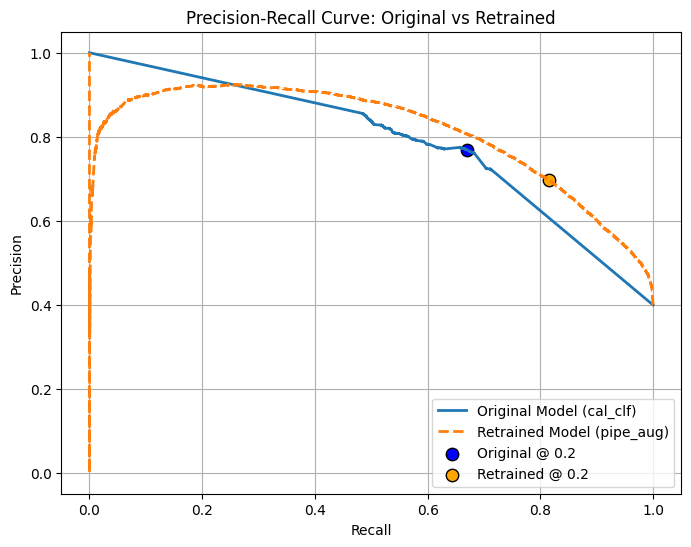

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate PR curves for both models
probs_orig = cal_clf.predict_proba(X_unseen)[:, 1]
prec_orig, rec_orig, _ = precision_recall_curve(y_unseen, probs_orig)

probs_new = pipe_aug.predict_proba(X_unseen)[:, 1]
prec_new, rec_new, _ = precision_recall_curve(y_unseen, probs_new)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(rec_orig, prec_orig, label="Original Model (cal_clf)", lw=2)
plt.plot(rec_new, prec_new, label="Retrained Model (pipe_aug)", lw=2, linestyle='--')

# Mark your tuned threshold on each curve
from sklearn.metrics import precision_score, recall_score

def get_pr_at_threshold(model, X, y, thr):
    preds = (model.predict_proba(X)[:, 1] >= thr).astype(int)
    return precision_score(y, preds), recall_score(y, preds)

p_o, r_o = get_pr_at_threshold(cal_clf, X_unseen, y_unseen, THRESHOLD)
p_n, r_n = get_pr_at_threshold(pipe_aug, X_unseen, y_unseen, THRESHOLD)

plt.scatter(r_o, p_o, color='blue', marker='o', s=80, edgecolor='k', label=f"Original @ {THRESHOLD}")
plt.scatter(r_n, p_n, color='orange', marker='o', s=80, edgecolor='k', label=f"Retrained @ {THRESHOLD}")

# Labels & legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Original vs Retrained")
plt.legend()
plt.grid(True)
plt.show()


In [123]:
# Print AUC comparison
print(f"AUC-PR Original Model:  {auc_pr_orig:.3f}")
print(f"AUC-PR Retrained Model: {auc_pr_new:.3f}")


AUC-PR Original Model:  0.790
AUC-PR Retrained Model: 0.811


Assess optimal threshold

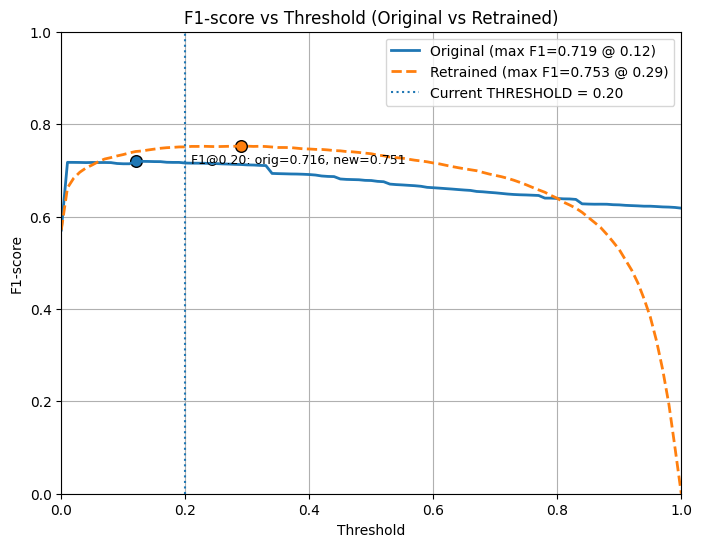

=== Best F1 (by threshold sweep) ===
Original:  F1=0.719 at threshold 0.12 (P=0.760, R=0.683)
Retrained: F1=0.753 at threshold 0.29 (P=0.733, R=0.773)

=== F1 at your current threshold ===
Original @ 0.20:  F1=0.716
Retrained @ 0.20: F1=0.751


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assumes you already have:
# - cal_clf (original model), pipe_aug (retrained model)
# - X_unseen, y_unseen
# - THRESHOLD (your current chosen threshold, e.g., 0.20)

def f1_curve(model, X, y, thresholds):
    f1s, precisions, recalls = [], [], []
    probs = model.predict_proba(X)[:, 1]
    for t in thresholds:
        preds = (probs >= t).astype(int)
        precisions.append(precision_score(y, preds, zero_division=0))
        recalls.append(recall_score(y, preds, zero_division=0))
        f1s.append(f1_score(y, preds, zero_division=0))
    return np.array(f1s), np.array(precisions), np.array(recalls)

thresholds = np.linspace(0.00, 1.00, 101)

# Curves for both models
f1_orig, p_orig, r_orig = f1_curve(cal_clf, X_unseen, y_unseen, thresholds)
f1_new,  p_new,  r_new  = f1_curve(pipe_aug, X_unseen, y_unseen, thresholds)

# Best points
best_idx_orig = int(np.argmax(f1_orig))
best_t_orig   = float(thresholds[best_idx_orig])
best_f1_orig  = float(f1_orig[best_idx_orig])
best_p_orig   = float(p_orig[best_idx_orig])
best_r_orig   = float(r_orig[best_idx_orig])

best_idx_new = int(np.argmax(f1_new))
best_t_new   = float(thresholds[best_idx_new])
best_f1_new  = float(f1_new[best_idx_new])
best_p_new   = float(p_new[best_idx_new])
best_r_new   = float(r_new[best_idx_new])

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_orig, label=f"Original (max F1={best_f1_orig:.3f} @ {best_t_orig:.2f})", lw=2)
plt.plot(thresholds, f1_new,  label=f"Retrained (max F1={best_f1_new:.3f} @ {best_t_new:.2f})", lw=2, linestyle="--")

# Mark best points
plt.scatter([best_t_orig], [best_f1_orig], s=70, edgecolor="k")
plt.scatter([best_t_new],  [best_f1_new],  s=70, edgecolor="k")

# Mark your current threshold
# (Optional) compute F1 at your chosen THRESHOLD for annotation
def f1_at(model, X, y, thr):
    preds = (model.predict_proba(X)[:,1] >= thr).astype(int)
    return f1_score(y, preds, zero_division=0)

f1_at_orig = f1_at(cal_clf, X_unseen, y_unseen, THRESHOLD)
f1_at_new  = f1_at(pipe_aug, X_unseen, y_unseen, THRESHOLD)

plt.axvline(THRESHOLD, linestyle=":", label=f"Current THRESHOLD = {THRESHOLD:.2f}")
plt.text(THRESHOLD+0.01, max(f1_orig.max(), f1_new.max())*0.95,
         f"F1@{THRESHOLD:.2f}: orig={f1_at_orig:.3f}, new={f1_at_new:.3f}",
         fontsize=9)

plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Threshold (Original vs Retrained)")
plt.legend()
plt.grid(True)
plt.show()

# Print numeric summaries
print("=== Best F1 (by threshold sweep) ===")
print(f"Original:  F1={best_f1_orig:.3f} at threshold {best_t_orig:.2f} (P={best_p_orig:.3f}, R={best_r_orig:.3f})")
print(f"Retrained: F1={best_f1_new:.3f} at threshold {best_t_new:.2f} (P={best_p_new:.3f}, R={best_r_new:.3f})")

print("\n=== F1 at your current threshold ===")
print(f"Original @ {THRESHOLD:.2f}:  F1={f1_at_orig:.3f}")
print(f"Retrained @ {THRESHOLD:.2f}: F1={f1_at_new:.3f}")


View confidence score of old and new model prediction

In [127]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model_with_conf(model, X, y, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    metrics = {
        "Accuracy": accuracy_score(y, preds),
        "Precision": precision_score(y, preds, zero_division=0),
        "Recall": recall_score(y, preds, zero_division=0),
        "F1": f1_score(y, preds, zero_division=0)
    }
    results_df = pd.DataFrame({
        "True_Label": y,
        "Predicted_Label": preds,
        "Confidence_Score": probs
    })
    return metrics, results_df

# --- Evaluate both models ---
orig_metrics, orig_preds_df = evaluate_model_with_conf(cal_clf, X_unseen, y_unseen, THRESHOLD)
new_metrics, new_preds_df  = evaluate_model_with_conf(pipe_aug, X_unseen, y_unseen, THRESHOLD)

# --- Metrics comparison ---
metrics_df = pd.DataFrame([orig_metrics, new_metrics],
                           index=["Original Model", "Retrained Model"])
print("\n=== Performance Comparison on Unseen Dataset ===")
print(metrics_df.to_markdown())

# --- Detailed classification reports ---
print("\n--- Original Model Classification Report ---")
print(classification_report(y_unseen, orig_preds_df["Predicted_Label"], zero_division=0))

print("\n--- Retrained Model Classification Report ---")
print(classification_report(y_unseen, new_preds_df["Predicted_Label"], zero_division=0))



=== Performance Comparison on Unseen Dataset ===
|                 |   Accuracy |   Precision |   Recall |       F1 |
|:----------------|-----------:|------------:|---------:|---------:|
| Original Model  |   0.787545 |    0.768253 | 0.670018 | 0.715781 |
| Retrained Model |   0.783977 |    0.696058 | 0.814729 | 0.750732 |

--- Original Model Classification Report ---
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     17508
           1       0.77      0.67      0.72     11637

    accuracy                           0.79     29145
   macro avg       0.78      0.77      0.77     29145
weighted avg       0.79      0.79      0.78     29145


--- Retrained Model Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.76      0.81     17508
           1       0.70      0.81      0.75     11637

    accuracy                           0.78     29145
   macro avg       0.78      0.79   

In [128]:
# --- Side-by-side predictions & confidence ---
combined_df = pd.DataFrame({
    "True_Label": y_unseen,
    "Orig_Pred": orig_preds_df["Predicted_Label"],
    "Orig_Conf": orig_preds_df["Confidence_Score"],
    "New_Pred": new_preds_df["Predicted_Label"],
    "New_Conf": new_preds_df["Confidence_Score"]
})
print("\n=== Sample Predictions with Confidence Scores ===")
print(combined_df.head(20).to_markdown())


=== Sample Predictions with Confidence Scores ===
|    |   True_Label |   Orig_Pred |   Orig_Conf |   New_Pred |   New_Conf |
|---:|-------------:|------------:|------------:|-----------:|-----------:|
|  0 |            1 |           0 |           0 |          0 |  0.0291728 |
|  1 |            1 |           0 |           0 |          0 |  0.118237  |
|  2 |            1 |           0 |           0 |          0 |  0.105302  |
|  3 |            1 |           0 |           0 |          0 |  0.0394636 |
|  4 |            1 |           0 |           0 |          0 |  0.051128  |
|  5 |            1 |           0 |           0 |          0 |  0.0560512 |
|  6 |            1 |           0 |           0 |          0 |  0.071401  |
|  7 |            1 |           0 |           0 |          0 |  0.0900868 |
|  8 |            1 |           0 |           0 |          0 |  0.0862884 |
|  9 |            1 |           0 |           0 |          0 |  0.0323557 |
| 10 |            1 |           0 |  

Observation: pulling confidence score from current predict probability is not significant.